In [2]:
import os
import sys
import glob
import itertools
import random

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta

random.seed(1234)

%matplotlib inline

## Mondrian Processes

### Various Functions for Mondrian Processes

Sampling...

In [3]:
### SAMPLE MONDRIAN PROCESS ###
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

def comp_log_p_sample(theta_space, data):
    if theta_space[1] == None and theta_space[2] == None:
        if data.shape[0] == 0:
            return 0
        else:
            mu = np.mean(data, axis = 0)
            residual = data - mu
            cov = np.dot(residual.T , residual) / data.shape[0] + np.identity(data.shape[1])*0.001
            return np.log(multivariate_normal.pdf(data, mean=mu, cov=cov)).sum()
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    
    dim, pos = _, left_rec[_,1]
    idx_left = data[:,dim] < pos
    idx_right = data[:,dim] >= pos
    log_len_left =  np.log(pos - root_rec[dim,0])
    log_len_right = np.log(root_rec[dim,1] - pos)
    return comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])

Visualization...

In [4]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=5, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)
        
        
def print_tree_at_leaf(mp_tree, table):

    if mp_tree[1] == None and mp_tree[2] == None: 
        print table.shape
        return 1
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    cut_type = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]
    
    return print_tree_at_leaf(mp_tree[1], table_left) + print_tree_at_leaf(mp_tree[2], table_right)


## Mondrian Process Generative Model

We apply Mondrian Processes (MPs) to flow cytometry data, using the prior information in the table above to guide the axis-aligned cuts.  Instead of uniformly, we draw the cut proportion from $w \sim \text{Beta}(a_{0}, b_{0})$. 

Now let's re-implement the MP sampling function, accounting for the prior information...

In [5]:
### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    cut_history = [1] * theta_space.shape[0]
    
    return draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history)
    

def draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history):    
    
    if sum(cut_history) == 0 or table.shape[0] == 1:
        return (theta_space, None, None)

    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return (theta_space, None, None)

    
    low, medium, high, very_high = 0, 1, 100, 1000
    priority_dict = {'-1': low , '0': low, '1': low, 
                   '-1 0': medium, '0 1': medium,
                   '-1 0 1': high, '-1 1':very_high
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    

    dists = (theta_space[:,1] - theta_space[:,0])* types    
    lin_dim = np.sum(dists)
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    cut_history[d] = 0

    prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1]) + theta_space[d,0]
    
    cut_type = types_str[d]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]

    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x
    M_left = draw_informed_Mondrian_at_t(theta_left, table_left, priors_dict, list(cut_history))
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table_right, priors_dict,list(cut_history))
    
    return (theta_space, M_left, M_right)

def Mondrian_Gaussian_perturbation(theta_space, old_sample, stepsize):
    """
    Input: 
    theta_space: a rectangle
    old_sample: partioned theta_space of a mondrian process
    stepsize: gaussian std
    """
    if old_sample[1] == None and old_sample[2] == None:
        return (theta_space, None, None)
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(old_sample[0].shape[0]):
        if old_sample[0][_,1] > old_sample[1][0][_,1]:
            break    
    dim, pos = _, old_sample[1][0][_,1]
    # propose position of new cut
    good_propose = False
    while good_propose == False:
        new_pos = pos + np.random.normal(0,(old_sample[0][dim,1] - old_sample[0][dim,0])*stepsize,1)[0]
        if new_pos < theta_space[dim,1] and new_pos > theta_space[dim,0]:
            good_propose = True
    
    theta_left = np.copy(theta_space)
    theta_left[dim,1] = new_pos
    theta_right = np.copy(theta_space)
    theta_right[dim,0] = new_pos
    
    new_M_left= Mondrian_Gaussian_perturbation(theta_left, old_sample[1], stepsize)
    new_M_right = Mondrian_Gaussian_perturbation(theta_right, old_sample[2], stepsize)
    
    return (theta_space, new_M_left, new_M_right)

def comp_log_p_prior(theta_space, table, cut_history):
    """
    This function returns prior probability of a Mondrian process theta_space
    """
    if theta_space[1] == None and theta_space[2] == None:
        return 0
    
    log_prior = 0
    

    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim  = _
    beta_pos =  (left_rec[_,1] - left_rec[dim,0])/(root_rec[dim,1] - root_rec[dim, 0])
    
    prior_params = priors_dict[' '.join([str(int(x)) \
                                         for x in sorted(set(table[table.columns[dim]]))])]

    # compute the log likelihood of the first cut
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    low_priority, medium_priority, high_priority, very_high_priority = 0, 1, 100, 1000
    priority_dict = {'-1': low_priority , '0': low_priority, '1': low_priority, 
                   '-1 0': medium_priority, '0 1': medium_priority,
                   '-1 0 1': high_priority, '-1 1':very_high_priority
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    dists = (root_rec[:,1] - root_rec[:,0])* types    
    lin_dim = np.sum(dists)
    
    # probability of dim
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    log_prior  += np.log(dim_probs[dim])
    
    
    # probability of pos
    log_prior += np.log(beta.pdf(beta_pos, prior_params[0], prior_params[1]))
    
    # split the table
    cut_history[dim] = 0
    cut_type = types_str[dim]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[dim]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[dim]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[dim]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 1
        table_right = table.loc[idx_table_right]
        
        
        
    return log_prior + comp_log_p_prior(theta_space[1], table_left, list(cut_history)) \
        + comp_log_p_prior(theta_space[2], table_right, list(cut_history))

# Classification

In [6]:
def classify_cells(data, mp_tree, table, cell_type_name2idx):
    Y = np.array([1]*data.shape[0])
    
    if data.shape[0] == 0:
        return Y
    
    if mp_tree[1] == None and mp_tree[2] == None:
        if table.shape[0] > 1:
#            print "more than one clusters, number of data points:", data.shape[0]
            labels = [cell_type_name2idx[table.index[_]] for _ in range(table.shape[0])]
            return np.array(np.random.choice(labels, data.shape[0],replace = True))
        else:
            return Y * cell_type_name2idx[table.index[0]]
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim, pos = _, left_rec[_,1]
    
    # find labels that match dim info from table
    idx_table_left = table[table.columns[dim]] != 1
    table_left = table.loc[idx_table_left]

    idx_table_right = table[table.columns[dim]] != -1
    table_right = table.loc[idx_table_right]
    
    # find data INDICIES that go high / low on cut position in dimension dim
    idx_left = data[:,dim]  < pos
    idx_right = data[:,dim]  >= pos
    
    Y[idx_left] = classify_cells(data[idx_left],mp_tree[1],table_left, cell_type_name2idx)
    Y[idx_right] = classify_cells(data[idx_right],mp_tree[2],table_right, cell_type_name2idx)

    return Y

## Flow Cytometry Data

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [7]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

(14, 32)


In [8]:
from sklearn.utils import shuffle

N = data.shape[0]
new_df = shuffle(df)[:N]
X_subset = new_df[channels].values
data_subset = np.arcsinh((X_subset-1.)/5.)
Y_subset = np.array([cell_type_name2idx[_] for _ in new_df.cell_type])
N, d = data_subset.shape
print N,d

# rename table header 'HLA-DR' to 'HLADR' to prevent error from '-'
temp_headers = list(table)
temp_headers[29] = "HLADR"
table.columns = temp_headers
print table.columns

emp_bounds = np.array([(data_subset[:,i].min(), data_subset[:,i].max()) for i in range(d)])

104184 32
Index([u'CD45RA', u'CD133', u'CD19', u'CD22', u'CD11b', u'CD4', u'CD8',
       u'CD34', u'Flt3', u'CD20', u'CXCR4', u'CD235ab', u'CD45', u'CD123',
       u'CD321', u'CD14', u'CD33', u'CD47', u'CD11c', u'CD7', u'CD15', u'CD16',
       u'CD44', u'CD38', u'CD13', u'CD3', u'CD61', u'CD117', u'CD49d',
       u'HLADR', u'CD64', u'CD41'],
      dtype='object')


In [9]:
%%time

n_mcmc_chain = 50
n_mcmc_sample = 2000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]
logl_accepted_trace = [[] for _ in range(n_mcmc_chain)]
logl_complete_trace = [[] for _ in range(n_mcmc_chain)]
Y_predict_accepted_trace = [[] for _ in range(n_mcmc_chain)]
accuracy_accepted_trace = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(emp_bounds, table)
    log_p_sample = comp_log_p_sample(sample, data_subset)
    
    accepts[chain].append(sample)
    logl_accepted_trace[chain].append(log_p_sample)
    logl_complete_trace[chain].append(log_p_sample)


    
    Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
    accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
    accuracy_accepted_trace[chain].append(accuracy)
    Y_predict_accepted_trace[chain].append(Y_predict)
    
    for idx in range(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(emp_bounds,sample, mcmc_gaussin_std)
        new_log_p_sample = comp_log_p_sample(new_sample, data_subset) 
        logl_complete_trace[chain].append(log_p_sample)
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > (new_log_p_sample - log_p_sample):
                rejects[chain].append(new_sample)
        
        else:
            if new_log_p_sample <  log_p_sample:
                print "accepted some bad samples"
                
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
            logl_accepted_trace[chain].append(log_p_sample)
        
            Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
            accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
            accuracy_accepted_trace[chain].append(accuracy)
            Y_predict_accepted_trace[chain].append(Y_predict)
        
        if (idx+1) % 500 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))
            
    
    if (chain + 1) % 10 == 0:
        # prediction and visualization
        Y_predict = classify_cells(data_subset, accepts[chain][-1], table, cell_type_name2idx)
        accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
        print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)         
            
            
print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))
# 3 chain, 5000 samples

Drawing Chain 0 ...
Iteration 500, cummulative accepted sample size is 19
Iteration 1000, cummulative accepted sample size is 20
Iteration 1500, cummulative accepted sample size is 20
Iteration 2000, cummulative accepted sample size is 22
Drawing Chain 1 ...
Iteration 500, cummulative accepted sample size is 25
Iteration 1000, cummulative accepted sample size is 29
Iteration 1500, cummulative accepted sample size is 29
Iteration 2000, cummulative accepted sample size is 29
Drawing Chain 2 ...
Iteration 500, cummulative accepted sample size is 19
Iteration 1000, cummulative accepted sample size is 20
Iteration 1500, cummulative accepted sample size is 21
Iteration 2000, cummulative accepted sample size is 22
Drawing Chain 3 ...
Iteration 500, cummulative accepted sample size is 15
Iteration 1000, cummulative accepted sample size is 15
Iteration 1500, cummulative accepted sample size is 16
Iteration 2000, cummulative accepted sample size is 16
Drawing Chain 4 ...
Iteration 500, cummulati

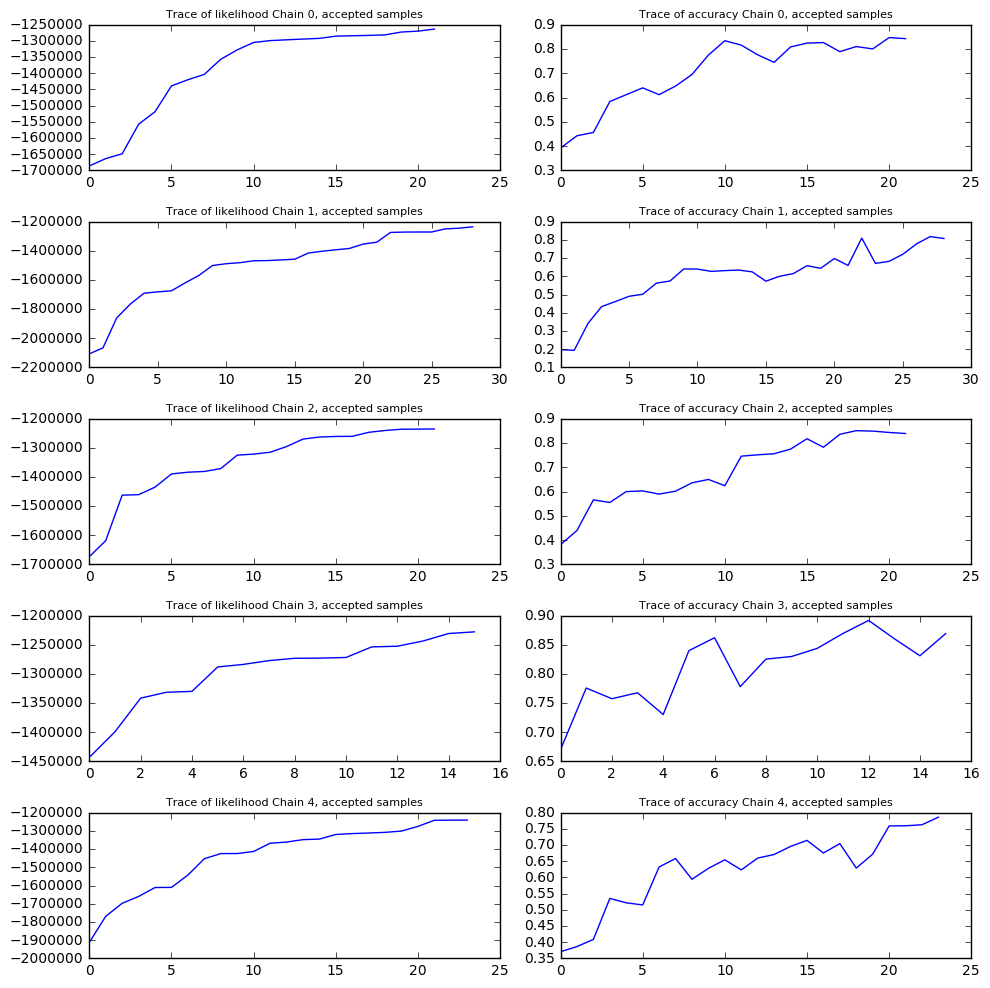

In [20]:
# # plot 5 chains
# fig, axs = plt.subplots(5, 3, figsize=(10,10) )
# for chain in range(5):
#     axs[chain, 0].plot(logl_complete_trace[chain])
#     axs[chain, 1].plot(logl_accepted_trace[chain])
#     axs[chain, 2].plot(accuracy_accepted_trace[chain])
#     axs[chain, 0].set_title('Trace of likelihood Chain %d, all samples' % chain, fontsize=8)
#     axs[chain, 1].set_title('Trace of likelihood Chain %d, accepted samples' % chain, fontsize=8)
#     axs[chain, 2].set_title('Trace of accuracy Chain %d, accepted samples' % chain, fontsize=8)
    
# fig.tight_layout()

# plot 5 chains
fig, axs = plt.subplots(5, 2, figsize=(10,10) )
for chain in range(5):
    axs[chain, 0].plot(logl_accepted_trace[chain])
    axs[chain, 1].plot(accuracy_accepted_trace[chain])
    axs[chain, 0].set_title('Trace of likelihood Chain %d, accepted samples' % chain, fontsize=8)
    axs[chain, 1].set_title('Trace of accuracy Chain %d, accepted samples' % chain, fontsize=8)
    
fig.tight_layout()

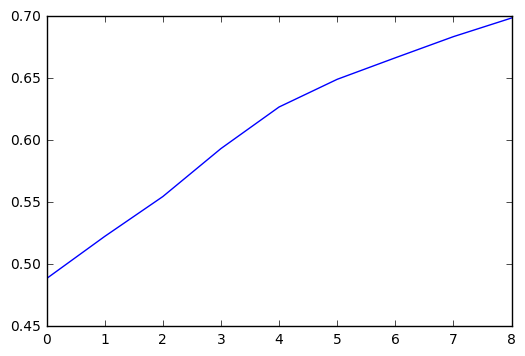

In [12]:
L = min(len(_) for _ in accuracy_accepted_trace)
res = []
for i in range(L):
    res.append(np.array([_[i] for _ in accuracy_accepted_trace]).mean())
plt.plot(res)

Accuracy on subset data: 0.922


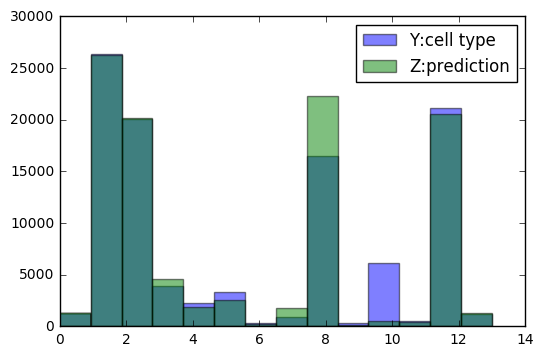

In [19]:
# keep the last 2 samples on each chain
burnt_samples = []
burnt_predictions = []
for i in range(len(accepts)):
    accepted_chain = accepts[i]
    likelihoods = logl_accepted_trace[i]
    predictions = Y_predict_accepted_trace[i]
    burnt_samples += [accepted_chain[_] for _ 
                      in range(len(accepted_chain) - 2,len(accepted_chain)) ]
    burnt_predictions += [predictions[_] for _ 
                          in range(len(accepted_chain) - 2,len(accepted_chain))]
    
# vote
votes = np.zeros([data_subset.shape[0], table.shape[0]])
for Y_predict in burnt_predictions:
    for _ in range(len(Y_predict)):
        votes[_,Y_predict[_]] += 1

Y_predict_majority = np.argmax(votes, axis=1)


accuracy = sum(Y_subset == Y_predict_majority)*1.0/ data_subset.shape[0]
print "Accuracy on subset data: %.3f" % (accuracy)

bins = table.shape[0]
plt.hist(Y_subset, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict_majority, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 

5209200.0
Chain  5 accuracy on subset data: 0.613


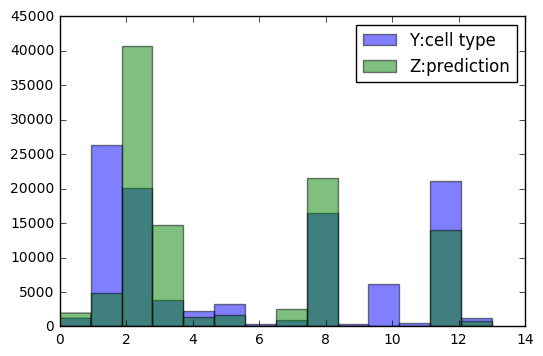

In [14]:
# emsemble 100 samples from prior

# vote
votes = np.zeros([data_subset.shape[0], table.shape[0]])

for i in range(n_mcmc_chain):
    Y_predict = Y_predict_accepted_trace[i][0]
    for _ in range(len(Y_predict)):
        votes[_,Y_predict[_]] += 1

Y_predict_majority = np.argmax(votes, axis=1)

print votes.sum()

accuracy = sum(Y_subset == Y_predict_majority)*1.0/ data_subset.shape[0]
print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)

bins = table.shape[0]
plt.hist(Y_subset, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict_majority, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 